### Partition face dataset into 8:2 training:test

### Apply PCA on training data by use of eigenvectors and eigenvalues of covaraiance matrix S= (1/N)A(A^T)

### Apply PCA using eigenvectors and eigenvalues of (1/N)(A^T)A

In [6]:
import numpy as np
from scipy.io import loadmat
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.ensemble import VotingClassifier
import csv

np.random.seed(42)

data = loadmat('face.mat')

X = data['X'] # flat images dim (2576,520)
# l = data['l'].flatten()  # image Labels (1,520)

# Does a 8/2 split of dataset (8 images / 2 images of each person). Training data shuffled. 
def Q1_partition(data):
    X = data['X'] # flat images dim (2576,520)
    l = data['l'].flatten() 
    sets = [[], [], [], []]
    for i in range(0, 520, 10):
        im_train, im_test, l_train, l_test = train_test_split(X[:, i: i + 10].T, l[i: i + 10], test_size=0.2, random_state=42)
        sets[0].append(im_train)    
        sets[1].append(im_test)  
        sets[2].append(l_train)    
        sets[3].append(l_test)  

    for i in range(4):
        if i < 2:
             sets[i] = np.array(sets[i]).reshape(-1, 2576)
        else: 
            sets[i] = np.array(sets[i]).flatten()
    
    return sets

In [7]:
def display_image(image, label):
    # X[:, image_index]
    image_height, image_width = 46, 56 
    image = image.reshape((image_height, image_width)).T 
    # label = l[image_index]

    plt.imshow(image, cmap='gray', aspect='auto')
    plt.title(f"Face Image - Label: {label}")
    plt.axis('off')
    plt.show()
    # display_image(X_train[1:2].T, "hey")
    # display_image(t1[i:i+1].T, "Hey")

def get_sorted_eigen(M):
    eigenvalues, eigenvectors = np.linalg.eig(M)
    eigenvalues, eigenvectors = np.real(eigenvalues), np.real(eigenvectors)

    sorted_indices = np.argsort(eigenvalues)[::-1]

    sorted_eigenvalues = eigenvalues[sorted_indices]
    sorted_eigenvectors = eigenvectors[:, sorted_indices]
    
    return sorted_eigenvalues, sorted_eigenvectors

# S = Covariance Matrix, A = mean centred data, N = #samples
def my_PCA(batch, k = 120, inverter = 0):
    A, mean, S = process_batch(batch, inverter)
    eigenvalues, eigenvectors = get_sorted_eigen(S)
    #k = choose_principal_components(threshold, eigenvalues)
    
    if inverter :
        eigenvectors = np.dot(A.T, eigenvectors)
        
        
    return eigenvalues[:k + 1], eigenvectors[:, :k + 1] / np.linalg.norm(eigenvectors[:, :k + 1], axis=0), mean, A

def choose_principal_components(threshold, eigenvalues):
    covariance_ratios = eigenvalues/np.sum(eigenvalues)
    cum_var = 0
    for k, ratio in enumerate(covariance_ratios):
        cum_var += ratio
        if cum_var >= threshold: return k 

def process_batch(batch, inverter):
    mean = np.mean(batch, axis=0)
    A = batch - mean
    print(f'batch: {batch.shape}')
    print(f'A: {A.shape}')
    N = A.shape[1]
    
    if inverter :
        S = (1/N) * np.dot(A, A.T)
    else :
        S = (1/N) * np.dot(A.T, A)
        
    print(f'S: {S.shape}')
    print(f'Mean: {mean.shape}')
    return A, mean, S

In [8]:
# S = Covariance Matrix, A = mean centred data, N = #samples per class, C = #classes
def my_LDA(batch, C, N, W, k = 120):
    mean, SB, SW = process_batch_LDA(batch, C, N, W)
    ST = np.linalg.inv(SW).dot(SB)
    print("ST : ", ST.shape)
    eigenvalues, eigenvectors = get_sorted_eigen(np.linalg.inv(SW).dot(SB))
    #k = choose_principal_components(threshold, eigenvalues) 
    #eigenvectors = np.dot(A.T, eigenvectors)
    
    eigenvectors = np.dot(ST, eigenvectors)
        
    return eigenvalues[:k], eigenvectors[:, :k], mean, SB, SW, ST

def process_batch_LDA(batch, C, N, W):
    print(f'batch: {batch.shape}')
    class_mean = np.array([np.mean(batch[i*N:(i+1)*N-1,:], axis=0) for i in range(C)])
    print(f'Class_mean: {class_mean.shape}') 
    mean = np.mean(class_mean, axis=0)
    print(f'Mean: {mean.shape}')
    
    SW = np.zeros((batch.shape[1], batch.shape[1]))
    for i, c_mean in enumerate(class_mean) :
        xn = batch[i*N:(i+1)*N-1,:] - c_mean
        for x in xn :
            SW += np.dot(x, x.T)
    print(f'SW: {SW.shape}')
    
    SB = np.zeros((batch.shape[1], batch.shape[1]))
    for c_mean in class_mean :
        SB += N * np.dot((c_mean - mean), (c_mean - mean).T)    
    print(f'SB: {SB.shape}')
        
    SW = W.T @ SW @ W
    SB = W.T @ SB @ W
    
    print(f'SW2: {SW.shape}')
    print(f'SB2: {SB.shape}')
    print("SW rank : ", np.linalg.matrix_rank(SW))
    print("SB rank : ", np.linalg.matrix_rank(SB))
    
    return mean, SW, SB

In [9]:
def deconstruct(image, eigenvects, mean):
    #Project and image on the eigenvectors
    
    reduced = image - mean
    projected = np.zeros((eigenvects.shape[1]))
    for i, vector in enumerate(eigenvects.T) :
        projected[i] = np.dot(reduced, vector)
    return projected

def reconstruct(projected, eigenvects, mean) :  
    #Reconstruct an image from its projection
          
    return mean + np.sum((eigenvects * projected), axis=1)

def test_image(img, eigenvects, mean, display=0):
    #Returns norm of reconstruction error, can display images
    
    projected = deconstruct(img, eigenvects, mean)
    re_image = reconstruct(projected, eigenvects, mean)
    
    if display :
        display_image(img, "Image 4")
        display_image(re_image, "Image 4 after reconstruct")
    return(np.linalg.norm(img-re_image))

In [10]:
[X_train, X_test, l_train, l_test] = Q1_partition(data)

eigenvalues_PCA, eigenvectors_PCA, mean_PCA, A = my_PCA(X_train, 200, 1)

print(A.shape, eigenvectors_PCA.shape)

Wpca = eigenvectors_PCA



batch: (416, 2576)
A: (416, 2576)
S: (416, 416)
Mean: (2576,)
(416, 2576) (2576, 201)


In [7]:
pca = PCA(n_components=400)
pca.fit(X_train)
Xr = pca.transform(X_train)
Xt = pca.transform(X_test)
W = pca.components_


eigenvalues, Wlda, mean, SB, SW, ST = my_LDA(X_train, 52, 8, Wpca, 51)
print(Wlda.shape, Wpca.shape)


batch: (416, 2576)
Class_mean: (52, 2576)
Mean: (2576,)
SW: (2576, 2576)
SB: (2576, 2576)
SW2: (201, 201)
SB2: (201, 201)
SW rank :  1
SB rank :  1
ST :  (201, 201)
(201, 51) (2576, 201)


In [8]:

print("Mean (2) : ", mean.shape)
print(f"SB : {SB.shape} - {np.linalg.matrix_rank(SB)} ; SW : {SW.shape} - {np.linalg.matrix_rank(SW)} ; ST : {ST.shape} - {np.linalg.matrix_rank(ST)}")

Wopt = np.dot(Wpca, Wlda)
print(Wopt.shape)

Mean (2) :  (2576,)
SB : (201, 201) - 1 ; SW : (201, 201) - 1 ; ST : (201, 201) - 201
(2576, 51)


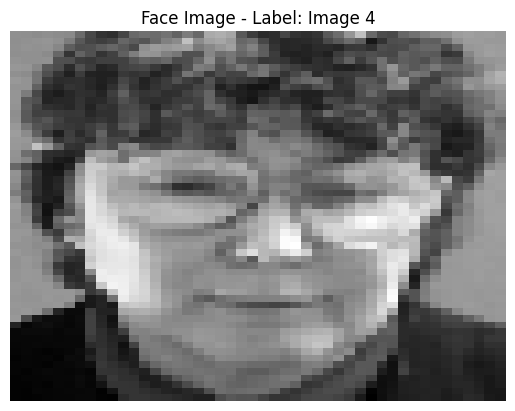

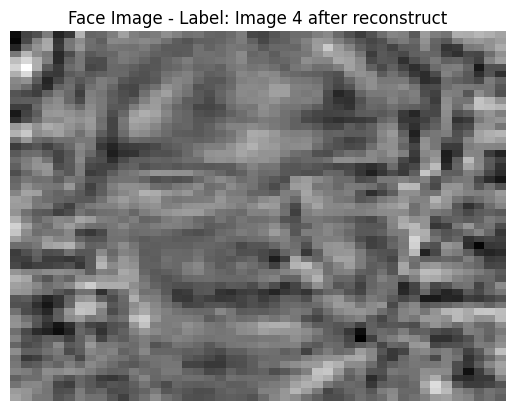

5150604.91896529


In [9]:
def test_image_LDA(img_or, img, eigenvects, mean, W, mean_PCA, display=0):
    #Returns norm of reconstruction error, can display images
    
    projected = deconstruct(img, eigenvects, mean)
    print(projected.shape, eigenvects.shape, mean.shape)
    re_image = reconstruct(reconstruct(projected, eigenvects, mean), W.T, mean_PCA)
    
    if display :
        display_image(img_or, "Image 4")
        display_image(re_image, "Image 4 after reconstruct")
    return(np.linalg.norm(img_or-re_image))


#projections = np.array([deconstruct(X_train[i], eigenvectors_PCA, mean_PCA) for i in range(len(X_train))])
#mean_projected = np.mean(projections, axis=0)
#print(mean_projected.shape)
#print(projections.shape)

print(test_image(X[:, 1], Wopt, mean_PCA, 1))
#print(test_image_LDA(X_train[1, :], Xr[1,:], eigenvectors, mean, W, mean_PCA, 1))
#print(test_image_LDA(X[:, 1] , eigenvectors, mean_projected, eigenvectors_PCA, mean_PCA, 1))
#print(np.mean([test_image_LDA(X[:, i], eigenvectors, mean_projected, eigenvectors_PCA, mean_PCA, 0) for i in range(len(X[0]))]))  #mean error


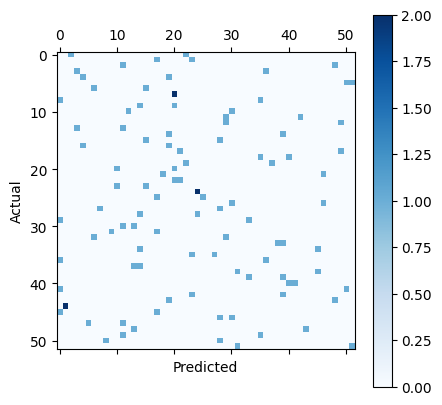

Accuracy :  0.11538461538461539


In [10]:
def testing_NN(image, projections, eigenvects, mean) :
    #Finds which training image correspond best to this image
    
    projected = deconstruct(image, eigenvects, mean)
    return np.argmin(np.linalg.norm((projections - projected), axis=1))

def fulltest(X_test, X_train, eigenvects, mean):
    #Compute all testing images and return guessed label
    
    projections = np.array([deconstruct(X_train[i], eigenvects, mean) for i in range(len(X_train))])
    res = []
    for image in X_test:
        res.append((testing_NN(image, projections, eigenvects, mean) //8) + 1)
    return np.array(res)

res = fulltest(X_test, X_train, Wopt, mean_PCA)

cm = confusion_matrix(l_test, res)

plt.matshow(cm, cmap = 'Blues')
plt.colorbar()
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

print("Accuracy : ", sum(np.equal(res, l_test))/len(res))

XR :  (416, 200)
Covariance :  (200, 200)


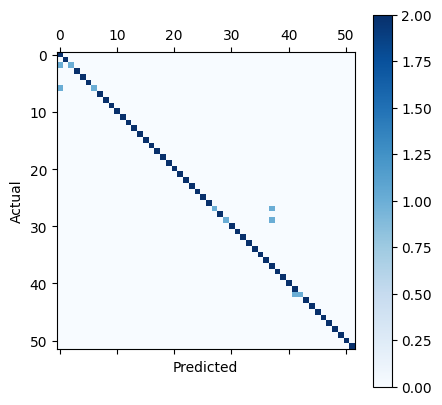

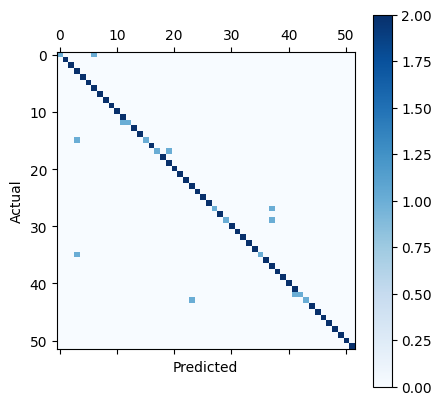

Accuracy (1) :  0.9519230769230769
Accuracy (2) :  0.9134615384615384


In [11]:
pca = PCA(n_components=200)
pca.fit(X_train)
Xr = pca.transform(X_train)
Xt = pca.transform(X_test)
print("XR : ", Xr.shape)

lda = LinearDiscriminantAnalysis(store_covariance = True)
lda.fit(X_train, l_train)
res = lda.predict(X_test)

lda = LinearDiscriminantAnalysis(solver="eigen")
lda.fit(Xr, l_train)
res2 = lda.predict(Xt)

print("Covariance : ", lda.covariance_.shape)

cm = confusion_matrix(l_test, res)

plt.matshow(cm, cmap = 'Blues')
plt.colorbar()
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

cm2 = confusion_matrix(l_test, res2)

plt.matshow(cm2, cmap = 'Blues')
plt.colorbar()
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

print("Accuracy (1) : ", sum(np.equal(res, l_test))/len(res))
print("Accuracy (2) : ", sum(np.equal(res2, l_test))/len(res2))

In [12]:
[X_train, X_test, l_train, l_test] = Q1_partition(data)

def Ensemble_data(X, y, T, f, C, Mlda):
    clfs = []
    for i in range(T) :
        X_sampled = []
        y_sampled = []
        for j in range(C):
            sampled_indices = np.random.choice(8, int(8*f), replace=True) + j*8
            X_sampled.append(X[sampled_indices])
            y_sampled.append(y[sampled_indices])
        X_sampled = np.concatenate(X_sampled)
        y_sampled = np.concatenate(y_sampled)
        lda = LinearDiscriminantAnalysis(n_components=Mlda)
        lda.fit(X_sampled, y_sampled)
        clfs.append(lda)
    return clfs
    
def Prediction_d(clfs, X_test, l_test, C):
    res = np.zeros((l_test.shape[0], C))
    for clf in clfs :
        res += clf.predict_proba(X_test)
    return np.argmax(res, axis=1) + 1
    


In [45]:

tot_results = []

for Mpca in range(60, 161, 10):
    print("PCA : ", Mpca)
    pca = PCA(n_components = Mpca)
    pca.fit(X_train)
    Xr = pca.transform(X_train)
    Xt = pca.transform(X_test)
    for Mlda in range(16, 47, 5):
        print("LDA : ", Mlda)
        for T in range(10, 19, 1):
            x = 5
            mean = 0
            for i in range(x):
                Classifiers = Ensemble_data(Xr, l_train, T, 0.95, 52, Mlda)
                res = Prediction_d(Classifiers, Xt, l_test, 52)
                mean += np.sum(np.equal(res, l_test))/len(res)
            tot_results.append([Mpca, Mlda, T, mean/x])
                
with open("output2.csv", mode="w", newline="") as file:
    writer = csv.writer(file)
    writer.writerows(tot_results)


PCA :  60
LDA :  16
LDA :  21
LDA :  26
LDA :  31
LDA :  36
LDA :  41
LDA :  46
PCA :  70
LDA :  16
LDA :  21
LDA :  26
LDA :  31
LDA :  36
LDA :  41
LDA :  46
PCA :  80
LDA :  16
LDA :  21
LDA :  26
LDA :  31
LDA :  36
LDA :  41
LDA :  46
PCA :  90
LDA :  16
LDA :  21
LDA :  26
LDA :  31
LDA :  36
LDA :  41
LDA :  46
PCA :  100
LDA :  16
LDA :  21
LDA :  26
LDA :  31
LDA :  36
LDA :  41
LDA :  46
PCA :  110
LDA :  16
LDA :  21
LDA :  26
LDA :  31
LDA :  36
LDA :  41
LDA :  46
PCA :  120
LDA :  16
LDA :  21
LDA :  26
LDA :  31
LDA :  36
LDA :  41
LDA :  46
PCA :  130
LDA :  16
LDA :  21
LDA :  26
LDA :  31
LDA :  36
LDA :  41
LDA :  46
PCA :  140
LDA :  16
LDA :  21
LDA :  26
LDA :  31
LDA :  36
LDA :  41
LDA :  46
PCA :  150
LDA :  16
LDA :  21
LDA :  26
LDA :  31
LDA :  36
LDA :  41
LDA :  46
PCA :  160
LDA :  16
LDA :  21
LDA :  26
LDA :  31
LDA :  36
LDA :  41
LDA :  46


In [44]:
pca = PCA(n_components=110)
pca.fit(X_train)
Xr = pca.transform(X_train)
Xt = pca.transform(X_test)

x = 10
mean = 0
for i in range(x):
    Classifiers = Ensemble_data(Xr, l_train, 20, 0.9, 52, 31)
    res = Prediction_d(Classifiers, Xt, l_test, 52)
    mean += np.sum(np.equal(res, l_test))/len(res)
print(mean/x)


0.9230769230769231


In [ ]:

"""
cm = confusion_matrix(l_test, res)

plt.matshow(cm, cmap = 'Blues')
plt.colorbar()
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()
"""

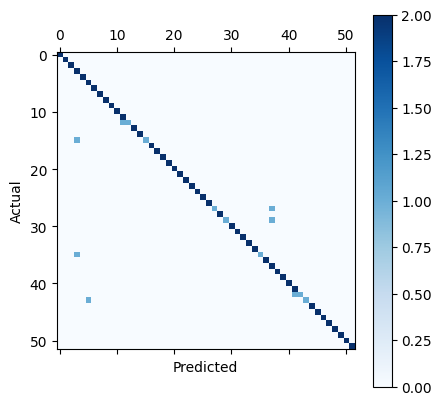

Accuracy :  0.9326923076923077


In [56]:
class RandomizedPCA_LDA(BaseEstimator, ClassifierMixin):
    def __init__(self, n_components_pca=5, n_components_lda=1, feature_ratio=0.8):
        self.n_components_pca = n_components_pca
        self.n_components_lda = n_components_lda
        self.feature_ratio = feature_ratio
        self.selected_features = None
        self.pca = None
        self.lda = None

    def fit(self, X, y):
        # Randomly select a subset of features
        n_features = X.shape[1]
        n_selected_features = int(n_features * self.feature_ratio)
        self.selected_features = np.random.choice(n_features, n_selected_features, replace=False)
        
        # Apply PCA on the selected features
        self.pca = PCA(n_components=self.n_components_pca)
        X_reduced = self.pca.fit_transform(X[:, self.selected_features])
        
        # Apply LDA on the PCA-transformed data
        self.lda = LinearDiscriminantAnalysis(n_components=self.n_components_lda)
        self.lda.fit(X_reduced, y)
        return self

    def predict(self, X):
        X_reduced = self.pca.transform(X[:, self.selected_features])
        return self.lda.predict_proba(X_reduced)
    
def Ensemble_feature(X, y, T, n_components_pca=5, n_components_lda=1, feature_ratio=0.8):
    classifiers = []
    for i in range(T):
        classifier = RandomizedPCA_LDA(n_components_pca, n_components_lda, feature_ratio)
        classifier.fit(X, y)
        classifiers.append(classifier)
    
    return classifiers

def Prediction_f(clfs, X_test, l_test, C):
    res = np.zeros((l_test.shape[0], C))
    for clf in clfs :
        res += clf.predict(X_test)
    return np.argmax(res, axis=1) + 1

Classifiers = Ensemble_feature(X_train, l_train, 10, 200, 51, 0.8)

res = Prediction_f(Classifiers, X_test, l_test, 52)

cm = confusion_matrix(l_test, res)

plt.matshow(cm, cmap = 'Blues')
plt.colorbar()
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

print("Accuracy : ", sum(np.equal(res, l_test))/len(res))
